In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch, torch.nn as nn, torch.nn.functional as F
# import torchvision.models as models
import lightning as L
from datasets import load_dataset

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
from torchvision.transforms import Compose, RandomVerticalFlip, RandomHorizontalFlip, RandomRotation, RandomErasing, ToTensor, CenterCrop, ToPILImage

In [5]:
dataset = load_dataset('../../astroclip/datasets/legacy_survey.py', 
                       cache_dir='/tmp/datasets'
                      )
dataset.set_format(type='torch', columns=['image', 'spectrum'])

image_transforms = Compose([
        # ToRGB(),
        # ToTensor(),
        RandomVerticalFlip(),
        RandomHorizontalFlip(),
        CenterCrop(96),
])

/tmp/ipykernel_4040161/748620904.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1694763734178/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  imshow(image_transforms(dataset['train'][0]['image'].T).T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


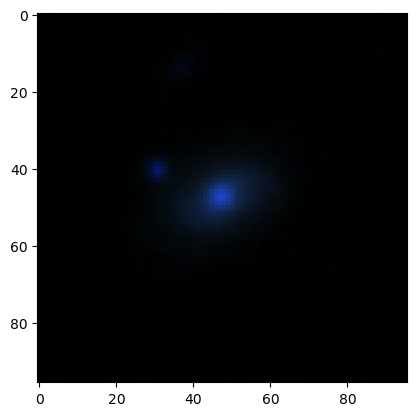

In [6]:
imshow(image_transforms(dataset['train'][0]['image'].T).T)

In [7]:
# Create the dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=512, shuffle=True, num_workers=8, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(dataset['test'], batch_size=512, shuffle=False, num_workers=8, drop_last=True)

In [8]:
# batch_ = next(iter(train_dataloader))

## Test George's embedding

In [9]:
class OutputExtractor(L.LightningModule):
    """
    Pass data through network to extract model outputs
    """
    def __init__(
        self,
        backbone: torch.nn.Module,
    ):    
        super(OutputExtractor, self).__init__()

        # pass
        self.backbone = backbone
        self.backbone.eval()

    def forward(self, batch):
        
        x, _ = batch
        
        z_emb = self.backbone(x)
       
        return z_emb
    
    def predict(self, batch, batch_idx: int, dataloader_idx: int=None):
        return self(batch)


from pl_bolts.models.self_supervised import Moco_v2

moco_model = Moco_v2.load_from_checkpoint(
                    checkpoint_path='/mnt/ceph/users/flanusse/resnet50.ckpt'
            )

# extract encoder_q from Moco_v2 model
backbone = moco_model.encoder_q

model = OutputExtractor(backbone).to('cuda')

/mnt/home/sgolkar/anaconda3/envs/fillm/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/mnt/home/sgolkar/anaconda3/envs/fillm/lib/python3.9/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/mnt/home/sgolkar/anaconda3/envs/fillm/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/mnt/home/sgolkar/anaconda3/envs/fillm/lib/pyt

In [10]:
# loading the ssl spectrum model. need to be on seqformer branch of fillm

from fillm.run.model import *

def load_model_from_ckpt(ckpt_path: str):
    """
    Load a model from a checkpoint.
    """
    if Path(ckpt_path).is_dir():
        ckpt_path = Path(ckpt_path) / "ckpt.pt"

    chkpt = torch.load(ckpt_path)
    config = chkpt["config"]
    state_dict = chkpt["model"]
    model_name = config["model"]['kind']
    model_keys = get_model_keys(model_name)
    # config['log_encoding']=False
    # config['log_decoding']=False
    # config['only_pred_masked']=True
    # config['first_layer_norm']=True
    # config['mlp_layer_norm']=True
    
    model_args = {k: config['model'][k] for k in model_keys}

    model_ctr, config_cls = model_registry[model_name]
    model_config = config_cls(**model_args)
    model_ = model_ctr(model_config)
    model_.load_state_dict(state_dict)

    return {"model": model_, "config": config}

model_path = "/mnt/home/sgolkar/ceph/saves/fillm/run-seqformer-2708117"
out = load_model_from_ckpt(model_path)

config = out['config']
spec_model = out['model'].cpu()
spec_model.eval()

print(spec_model)


Seqformer(
  (data_embed): Linear(in_features=22, out_features=768, bias=True)
  (position_embed): Embedding(800, 768)
  (dropout): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (layernorm1): LayerNorm()
      (attention): SelfAttention(
        (attention): Linear(in_features=768, out_features=2304, bias=True)
        (projection): Linear(in_features=768, out_features=768, bias=True)
        (attention_dropout): Dropout(p=0.0, inplace=False)
        (residual_dropout): Dropout(p=0.0, inplace=False)
      )
      (layernorm2): LayerNorm()
      (mlp): MLP(
        (activation): GELU(approximate='none')
        (encoder): Linear(in_features=768, out_features=3072, bias=True)
        (decoder): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (final_layernorm): LayerNorm()
  (head): Linear(in_features=768, out_features=22, bias=True)
)


In [11]:
# Modifying the forward to output all the embeddings.

import torch.nn.functional as F

def forward(
    self, x: torch.Tensor, y: Optional[torch.Tensor] = None
) -> Tuple[torch.Tensor, torch.Tensor]:
    device = x.device
    t = x.shape[1]

    # find the mask locations
    locs = x != y

    if t > self.config.block_size:
        raise ValueError(
            f"Cannot forward sequence of length {t}, "
            f"block size is only {self.config.block_size}"
        )
    pos = torch.arange(0, t, dtype=torch.long, device=device)  # shape (t)

    # forward the GPT model itself
    data_emb = self.data_embed(x)  # to shape (b, t, embedding_dim)
    pos_emb = self.position_embed(pos)  # to shape (t, embedding_dim)

    x = self.dropout(data_emb + pos_emb)
    for block in self.blocks:
        x = block(x)
    x = self.final_layernorm(x)
    embedding = x.detach().clone()

    preds = self.head(x)
    if y is not None:
        # if we are given some desired targets also calculate the loss
        locs = locs.type_as(preds)
        loss = F.mse_loss(preds * locs, y * locs, reduction="mean") / locs.mean()
    else:
        loss = None

    return {"preds": preds, "loss": loss, "embedding": embedding}


spec_model.forward = forward.__get__(spec_model, type(model))

In [12]:
# Defining the reshaping functions

# defining the new dataset

import numpy as np

def slice(x, section_length=10, overlap=5):

    start_indices = np.arange(0, x.shape[1] - overlap, section_length - overlap)
    sections = [x[:,start:start + section_length].transpose(1,2) for start in start_indices]

    # If the last section is not of length 'section_length', you can decide whether to keep or discard it
    if sections[-1].shape[1] < section_length:
        sections.pop(-1)  # Discard the last section  

    return torch.cat(sections, 1)


def fnc(x):
    std, mean = x.std(1, keepdim=True).clip_(0.2), x.mean(1, keepdim=True)
    x = (x - mean) / std
    x = slice(x, 20, 10)
    x = F.pad(x, pad=(2, 0, 1, 0), mode='constant', value=0)
    x[:,0,0] = (mean.squeeze()-2)/2
    x[:,0,1] = (std.squeeze()-2)/8     

    return x


In [132]:
# defining a decoder to turn the embeddings into 128 dims.
class seq_decoder(nn.Module):

    def __init__(self,  model, embed_dim=128, nhead=4, model_embed_dim=768, dropout=0.1):
        super().__init__()


        self.query = nn.Parameter(torch.randn(1, 1, embed_dim)) 
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=nhead, batch_first=True, kdim=model_embed_dim, vdim=model_embed_dim)
        self.model = model
        # go through the weights of the model and make them not require grad
        for param in self.model.parameters():
            param.requires_grad = False

        d_model = embed_dim
        dim_feedforward = 4 * d_model

        
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        
        self.norm = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.GELU()


    def forward(self, sample, return_weights=False):
        sample=sample.unsqueeze(-1)
        batch_size = len(sample)
        with torch.no_grad():
            embedding = self.model(fnc(sample))['embedding']

        attentions = self.multihead_attn(query=self.query.repeat(batch_size,1,1), key=embedding, value=embedding, need_weights=return_weights, average_attn_weights = False)
        x = self.norm(self.dropout1(attentions[0]))
        x = x+self.dropout2(self.linear2(self.dropout(self.activation(self.linear1(x)))))
        if return_weights:
            return x.squeeze(), attentions[1]
        return x.squeeze()


my_decoder = seq_decoder(model=spec_model)      

num_params = sum(p.numel() for p in my_decoder.parameters())
print(f"{num_params:,}")

43,539,734


/tmp/ipykernel_4040161/3145456241.py:47: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  num_params = sum(p.numel() for p in my_decoder.parameters())


In [133]:
my_decoder

seq_decoder(
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (model): Seqformer(
    (data_embed): Linear(in_features=22, out_features=768, bias=True)
    (position_embed): Embedding(800, 768)
    (dropout): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (layernorm1): LayerNorm()
        (attention): SelfAttention(
          (attention): Linear(in_features=768, out_features=2304, bias=True)
          (projection): Linear(in_features=768, out_features=768, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
          (residual_dropout): Dropout(p=0.0, inplace=False)
        )
        (layernorm2): LayerNorm()
        (mlp): MLP(
          (activation): GELU(approximate='none')
          (encoder): Linear(in_features=768, out_features=3072, bias=True)
          (decoder): Linear(in_features=3072, out_features=768, bias=True)
 

In [134]:
# Let's define our architectures
image_encoder = model # models.resnet34(num_classes=512, weights=None)
# spectrum_encoder = SpectrumEncoder(None, 128)
spectrum_encoder = my_decoder

## Actual training code

In [135]:
class CLIPLoss(nn.Module):
    def get_logits(self, image_features, spectrum_features, logit_scale):
        image_features = F.normalize(image_features, dim=-1, eps=1e-3)
        spectrum_features = F.normalize(spectrum_features, dim=-1, eps=1e-3)
        logits_per_image = logit_scale * image_features @ spectrum_features.T
        return logits_per_image, logits_per_image.T

    def forward(self, image_features, spectrum_features, logit_scale, output_dict=False):
        logits_per_image, logits_per_spectrum = self.get_logits(image_features, spectrum_features, logit_scale)
        labels = torch.arange(logits_per_image.shape[0], device=image_features.device, dtype=torch.long)
        total_loss = (
            F.cross_entropy(logits_per_image, labels) +
            F.cross_entropy(logits_per_spectrum, labels)
        ) / 2
        return {"contrastive_loss": total_loss} if output_dict else total_loss

In [136]:
import torch.optim.lr_scheduler as lr_scheduler

class LitCLIP(L.LightningModule):
    def __init__(self, image_encoder, spectrum_encoder):
        super().__init__()
        self.image_encoder = image_encoder
        # self.image_encoder.freeze()
        
        # Freeze all but the last layers
        for name, child in self.image_encoder.backbone.named_children():
            if name != 'fc':
                for param in child.parameters():
                    param.requires_grad = False

        self.spectrum_encoder = spectrum_encoder
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(15.5))
        self.criterion = CLIPLoss()
        
    def forward(self, x, image=True, return_weights=False):
        if image:
            embedding = self.image_encoder((x,None))
        else:
            embedding = self.spectrum_encoder(x, return_weights=return_weights)
        return embedding


    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        im, sp = batch['image'].transpose(1,3), batch['spectrum'].squeeze()
        im = image_transforms(im)#.to('cuda')
        image_features = self.image_encoder((im, None))
        spectrum_features = self.spectrum_encoder(sp)
        
        loss_withlogit = self.criterion(image_features, spectrum_features, 15.5)
        self.log("train_loss_withlogit", loss_withlogit)
        loss_nologit = self.criterion(image_features, spectrum_features, 1)
        self.log("train_loss_nologit", loss_nologit)
        self.log("scale", self.logit_scale)
        return loss_withlogit

    def validation_step(self, batch, batch_idx):
        im, sp = batch['image'].transpose(1,3), batch['spectrum'].squeeze()
        im = image_transforms(im)#.to('cpu').numpy()).to('cuda')
        image_features = self.image_encoder((im, None))
        spectrum_features = self.spectrum_encoder(sp)
        val_loss_nologit = self.criterion(image_features, spectrum_features, 1)
        self.log("val_loss_nologit", val_loss_nologit)
        val_loss_withlogit = self.criterion(image_features, spectrum_features, 15.5)
        self.log("val_loss_withlogit", val_loss_withlogit)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=5e-5, weight_decay=0.2)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=5e-6)
        return {
        'optimizer': optimizer,
        'lr_scheduler': {
            'scheduler': scheduler,
            'interval': 'epoch',  # or 'step' for step-wise updating
            'frequency': 1,  # how often to apply
        }
    }

In [137]:
CLIP = LitCLIP(image_encoder, spectrum_encoder)

In [19]:
import wandb
wandb.finish()

In [20]:
from lightning.pytorch.callbacks import ModelCheckpoint,LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project="astroclip-clip-align", entity="flatiron-scipt")
lr_monitor = LearningRateMonitor(logging_interval='step') 

trainer = L.Trainer(
        max_epochs=-1,
        logger=wandb_logger,
        callbacks=[
            lr_monitor,
            ModelCheckpoint(
                every_n_epochs=1,
                save_top_k=2,
                monitor="val_loss_nologit",
            )],
            )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: golkar (flatiron-scipt). Use `wandb login --relogin` to force relogin
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


/mnt/home/sgolkar/anaconda3/envs/fillm/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/sgolkar/anaconda3/envs/fillm/lib/python3.9 ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
torch.set_float32_matmul_precision('medium')
trainer.fit(model=CLIP, 
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

## Looking at the results

In [138]:
# Loading the last saved checkpoint
CLIP = LitCLIP.load_from_checkpoint('/mnt/home/sgolkar/projects/AstroCLIP/notebooks/dev/astroclip-clip-align/73j9jeic/checkpoints/epoch=160-step=49749.ckpt',
                                 image_encoder=image_encoder, 
                                 spectrum_encoder=spectrum_encoder)

In [25]:
from tqdm import tqdm

import numpy as np
import h5py
from PIL import Image as im

def sdss_rgb(imgs, bands, scales=None,
             m = 0.02):
    import numpy as np
    rgbscales = {'u': (2,1.5), #1.0,
                 'g': (2,2.5),
                 'r': (1,1.5),
                 'i': (0,1.0),
                 'z': (0,0.4), #0.3
                 }
    if scales is not None:
        rgbscales.update(scales)

    I = 0
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        img = np.maximum(0, img * scale + m)
        I = I + img
    I /= len(bands)
    Q = 20
    fI = np.arcsinh(Q * I) / np.sqrt(Q)
    I += (I == 0.) * 1e-6
    H,W = I.shape
    rgb = np.zeros((H,W,3), np.float32)
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        rgb[:,:,plane] = (img * scale + m) * fI / I
    rgb = np.clip(rgb, 0, 1)
    return rgb

def dr2_rgb(rimgs, bands, **ignored):
    return sdss_rgb(rimgs, bands, scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)

dataset.set_format(type='torch', columns=['image', 'spectrum', 'redshift', 'targetid'])
testdata = torch.utils.data.DataLoader(dataset['test'], batch_size=512, shuffle=False, num_workers=10)

embeddings = []
images = []
redshifts = []
spectra = []
source_spec = []
tids = []
for batch_test in tqdm(testdata):
    images.append(np.stack([clip(dr2_rgb(i.cpu().T, bands=['g', 'r', 'z']),0,1) for i in batch_test['image']] ,axis=0))
    spectra.append(CLIP(batch_test['spectrum'].squeeze().to('cuda'), False).detach().cpu().numpy())
    embeddings.append(CLIP(image_transforms(batch_test['image'].transpose(1,3).to('cuda'))).detach().cpu().numpy())
    redshifts.append(batch_test['redshift'])
    source_spec.append(batch_test['spectrum'])
    tids.append(batch_test['targetid'])

images = np.concatenate(images, axis=0)
spectra = np.concatenate(spectra, axis=0)
embeddings = np.concatenate(embeddings, axis=0)
redshifts = np.concatenate(redshifts, axis=0)
source_spec = np.concatenate(source_spec, axis=0)
targetids = np.concatenate(tids, axis=0)

np.savez('../data/siavash_embeddings_73j9jeic_1p1p4.npz', 
         redshift=redshifts,
         image_features=embeddings,
         spectrum_features=spectra,
         images=images,
         spectra=source_spec,
         targetid=targetids)

100%|██████████| 78/78 [04:16<00:00,  3.29s/it]


In [26]:
dataset = load_dataset('../../astroclip/datasets/legacy_survey.py', 
                       cache_dir='/tmp'
                      )
dataset.set_format(type='torch', columns=['image', 'spectrum'])

image_transforms = Compose([
        # ToRGB(),
        # ToTensor(),
        RandomVerticalFlip(),
        RandomHorizontalFlip(),
        CenterCrop(96),
])

In [27]:
from tqdm import tqdm

import numpy as np
import h5py
from PIL import Image as im

def sdss_rgb(imgs, bands, scales=None,
             m = 0.02):
    import numpy as np
    rgbscales = {'u': (2,1.5), #1.0,
                 'g': (2,2.5),
                 'r': (1,1.5),
                 'i': (0,1.0),
                 'z': (0,0.4), #0.3
                 }
    if scales is not None:
        rgbscales.update(scales)

    I = 0
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        img = np.maximum(0, img * scale + m)
        I = I + img
    I /= len(bands)
    Q = 20
    fI = np.arcsinh(Q * I) / np.sqrt(Q)
    I += (I == 0.) * 1e-6
    H,W = I.shape
    rgb = np.zeros((H,W,3), np.float32)
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        rgb[:,:,plane] = (img * scale + m) * fI / I
    rgb = np.clip(rgb, 0, 1)
    return rgb

def dr2_rgb(rimgs, bands, **ignored):
    return sdss_rgb(rimgs, bands, scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)

dataset.set_format(type='torch', columns=['image', 'spectrum', 'redshift', 'targetid'])
testdata = torch.utils.data.DataLoader(dataset['test'], batch_size=512, shuffle=False, num_workers=10)

embeddings = []
images = []
redshifts = []
spectra = []
source_spec = []
tids = []
for batch_test in tqdm(testdata):
    images.append(np.stack([clip(dr2_rgb(i.cpu().T, bands=['g', 'r', 'z']),0,1) for i in batch_test['image']] ,axis=0))
    spectra.append(CLIP(batch_test['spectrum'].squeeze().to('cuda'), False).detach().cpu().numpy())
    embeddings.append(CLIP(image_transforms(batch_test['image'].transpose(1,3).to('cuda'))).detach().cpu().numpy())
    redshifts.append(batch_test['redshift'])
    source_spec.append(batch_test['spectrum'])
    tids.append(batch_test['targetid'])

images = np.concatenate(images, axis=0)
spectra = np.concatenate(spectra, axis=0)
embeddings = np.concatenate(embeddings, axis=0)
redshifts = np.concatenate(redshifts, axis=0)
source_spec = np.concatenate(source_spec, axis=0)
targetids = np.concatenate(tids, axis=0)

np.savez('../data/siavash_embeddings_73j9jeic_1p1p5.npz', 
         redshift=redshifts,
         image_features=embeddings,
         spectrum_features=spectra,
         images=images,
         spectra=source_spec,
         targetid=targetids)

100%|██████████| 78/78 [04:04<00:00,  3.14s/it]


In [31]:
batch_test['spectrum'][:1].squeeze().shape

torch.Size([7781])

In [68]:
spec.shape

(778, 22)

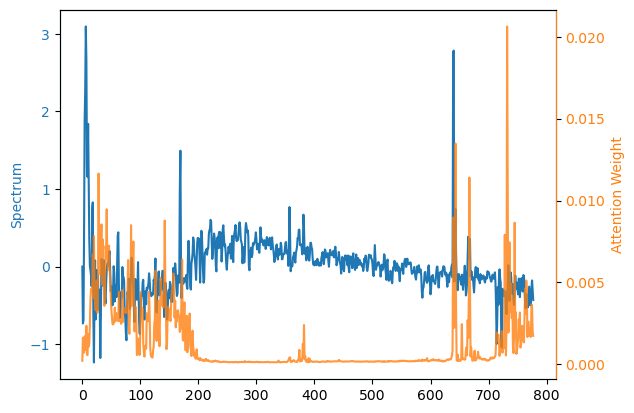

In [85]:
spec = fnc(batch_test['spectrum'])[0].squeeze().cpu().numpy()
att_weight = CLIP(batch_test['spectrum'].squeeze()[:1].to('cuda'), False, return_weights=True)[1]

fig, ax = subplots()
plot(spec[:,2:].mean(1), color='tab:blue', label='spectrum')
ax.set_ylabel('Spectrum')
ax.set_ylabel('Spectrum', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
for spine in ["left", "bottom"]:
    ax.spines[spine].set_edgecolor('tab:blue')


# twinx
ax2 = ax.twinx()
ax2.plot(att_weight.squeeze().data.cpu(), label='attention weight', color='tab:orange', alpha=0.8)
ax2.set_ylabel('Attention Weight')
ax2.set_ylabel('Attention Weight', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
for spine in ["right"]:
    ax2.spines[spine].set_edgecolor('tab:orange')

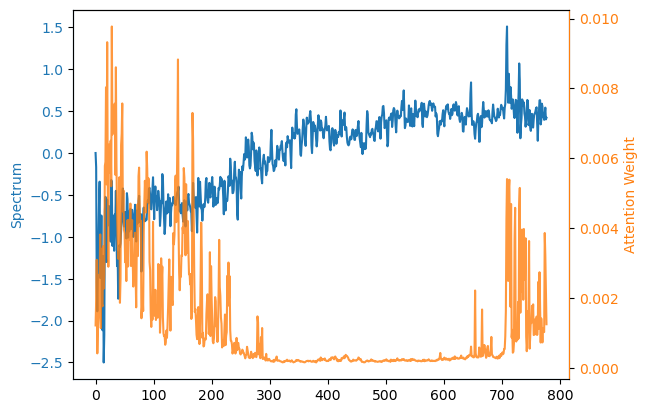

In [87]:
idx = 1

spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weight = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1]

fig, ax = subplots()
plot(spec[:,2:].mean(1), color='tab:blue', label='spectrum')
ax.set_ylabel('Spectrum')
ax.set_ylabel('Spectrum', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
for spine in ["left", "bottom"]:
    ax.spines[spine].set_edgecolor('tab:blue')


# twinx
ax2 = ax.twinx()
ax2.plot(att_weight.squeeze().data.cpu(), label='attention weight', color='tab:orange', alpha=0.8)
ax2.set_ylabel('Attention Weight')
ax2.set_ylabel('Attention Weight', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
for spine in ["right"]:
    ax2.spines[spine].set_edgecolor('tab:orange')

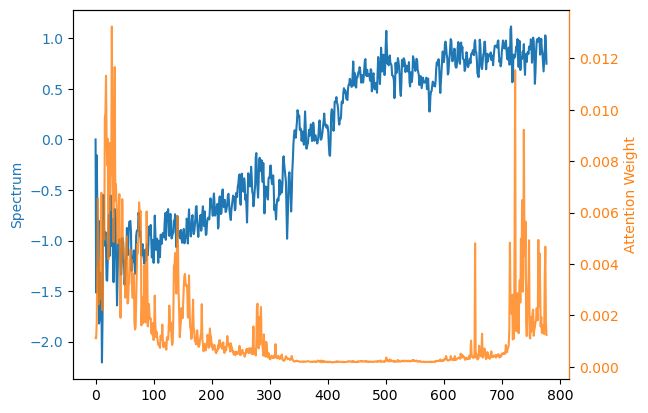

In [88]:
idx = 2

spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weight = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1]

fig, ax = subplots()
plot(spec[:,2:].mean(1), color='tab:blue', label='spectrum')
ax.set_ylabel('Spectrum')
ax.set_ylabel('Spectrum', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
for spine in ["left", "bottom"]:
    ax.spines[spine].set_edgecolor('tab:blue')


# twinx
ax2 = ax.twinx()
ax2.plot(att_weight.squeeze().data.cpu(), label='attention weight', color='tab:orange', alpha=0.8)
ax2.set_ylabel('Attention Weight')
ax2.set_ylabel('Attention Weight', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
for spine in ["right"]:
    ax2.spines[spine].set_edgecolor('tab:orange')

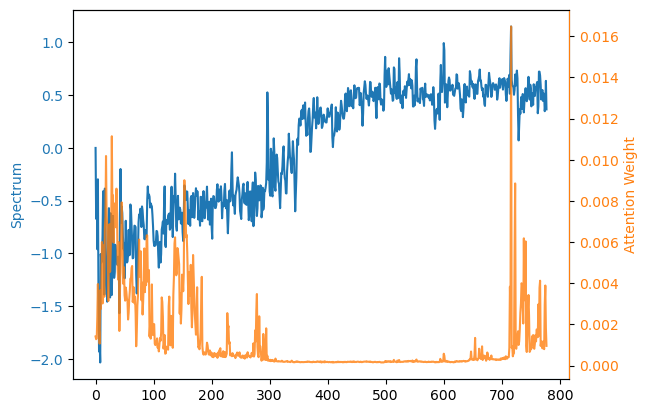

In [89]:
idx = 3

spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weight = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1]

fig, ax = subplots()
plot(spec[:,2:].mean(1), color='tab:blue', label='spectrum')
ax.set_ylabel('Spectrum')
ax.set_ylabel('Spectrum', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
for spine in ["left", "bottom"]:
    ax.spines[spine].set_edgecolor('tab:blue')


# twinx
ax2 = ax.twinx()
ax2.plot(att_weight.squeeze().data.cpu(), label='attention weight', color='tab:orange', alpha=0.8)
ax2.set_ylabel('Attention Weight')
ax2.set_ylabel('Attention Weight', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
for spine in ["right"]:
    ax2.spines[spine].set_edgecolor('tab:orange')

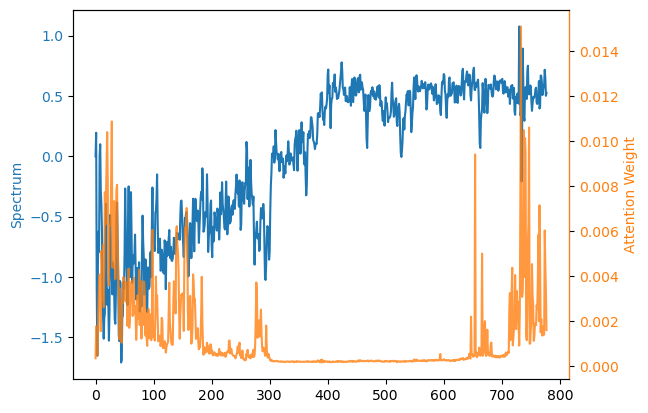

In [90]:
idx = 4

spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weight = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1]

fig, ax = subplots()
plot(spec[:,2:].mean(1), color='tab:blue', label='spectrum')
ax.set_ylabel('Spectrum')
ax.set_ylabel('Spectrum', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
for spine in ["left", "bottom"]:
    ax.spines[spine].set_edgecolor('tab:blue')


# twinx
ax2 = ax.twinx()
ax2.plot(att_weight.squeeze().data.cpu(), label='attention weight', color='tab:orange', alpha=0.8)
ax2.set_ylabel('Attention Weight')
ax2.set_ylabel('Attention Weight', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
for spine in ["right"]:
    ax2.spines[spine].set_edgecolor('tab:orange')

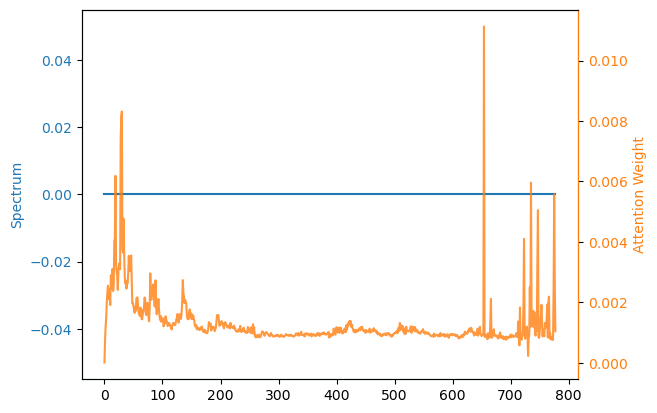

In [91]:
idx = 5

spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weight = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1]

fig, ax = subplots()
plot(spec[:,2:].mean(1), color='tab:blue', label='spectrum')
ax.set_ylabel('Spectrum')
ax.set_ylabel('Spectrum', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
for spine in ["left", "bottom"]:
    ax.spines[spine].set_edgecolor('tab:blue')


# twinx
ax2 = ax.twinx()
ax2.plot(att_weight.squeeze().data.cpu(), label='attention weight', color='tab:orange', alpha=0.8)
ax2.set_ylabel('Attention Weight')
ax2.set_ylabel('Attention Weight', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
for spine in ["right"]:
    ax2.spines[spine].set_edgecolor('tab:orange')

In [144]:
att_weight.shape

torch.Size([4, 778])

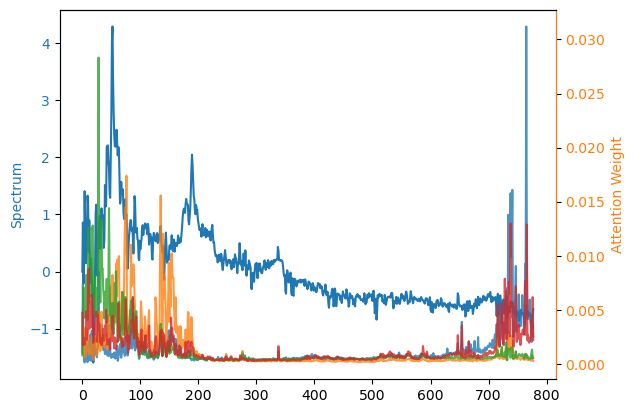

In [146]:
idx = 6

spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

fig, ax = subplots()
plot(spec[:,2:].mean(1), color='tab:blue', label='spectrum')
ax.set_ylabel('Spectrum')
ax.set_ylabel('Spectrum', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
for spine in ["left", "bottom"]:
    ax.spines[spine].set_edgecolor('tab:blue')


# twinx
ax2 = ax.twinx()
for att_weight in att_weights:
    ax2.plot(att_weight.squeeze().data.cpu(), label='attention weight', alpha=0.8)
ax2.set_ylabel('Attention Weight')
ax2.set_ylabel('Attention Weight', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
for spine in ["right"]:
    ax2.spines[spine].set_edgecolor('tab:orange')

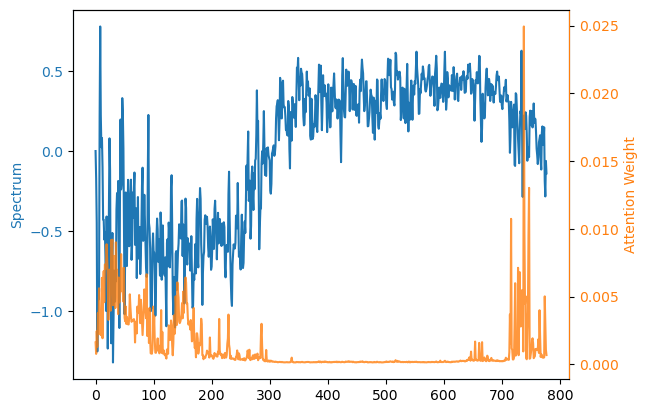

In [93]:
idx = 7

spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weight = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1]

fig, ax = subplots()
plot(spec[:,2:].mean(1), color='tab:blue', label='spectrum')
ax.set_ylabel('Spectrum')
ax.set_ylabel('Spectrum', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
for spine in ["left", "bottom"]:
    ax.spines[spine].set_edgecolor('tab:blue')


# twinx
ax2 = ax.twinx()
ax2.plot(att_weight.squeeze().data.cpu(), label='attention weight', color='tab:orange', alpha=0.8)
ax2.set_ylabel('Attention Weight')
ax2.set_ylabel('Attention Weight', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
for spine in ["right"]:
    ax2.spines[spine].set_edgecolor('tab:orange')

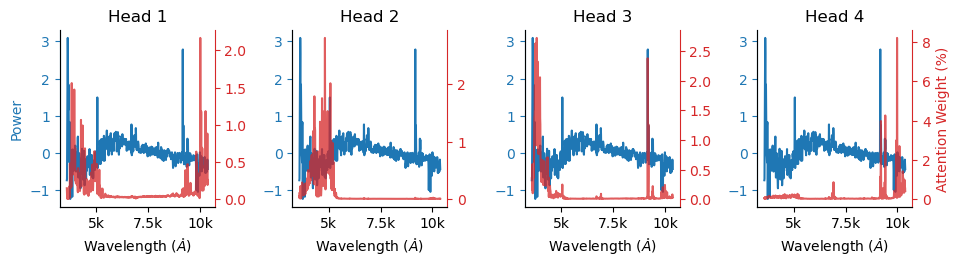

In [245]:
idx = 0

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_1.png', bbox_inches='tight', dpi=300)

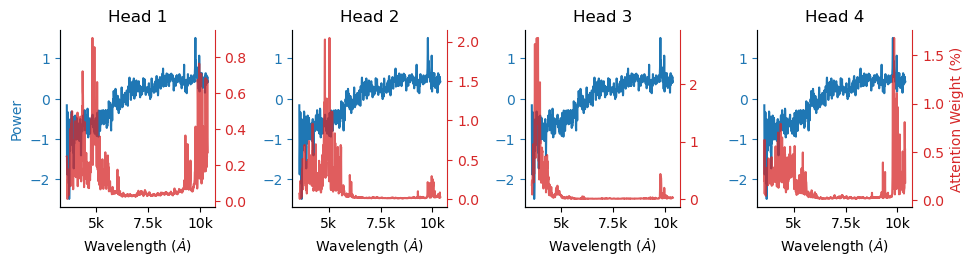

In [246]:
idx = 1

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_2.png', bbox_inches='tight', dpi=300)

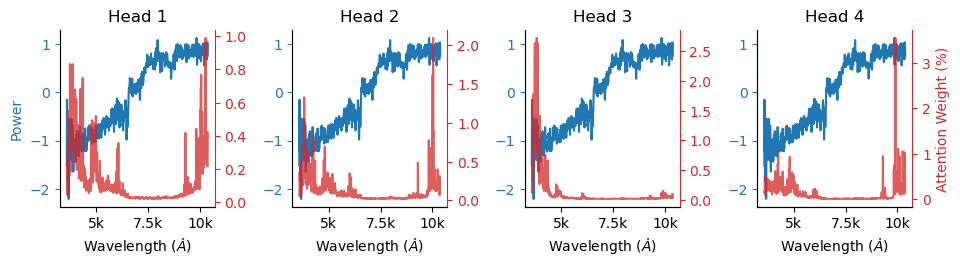

In [247]:
idx = 2

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_3.png', bbox_inches='tight', dpi=300)

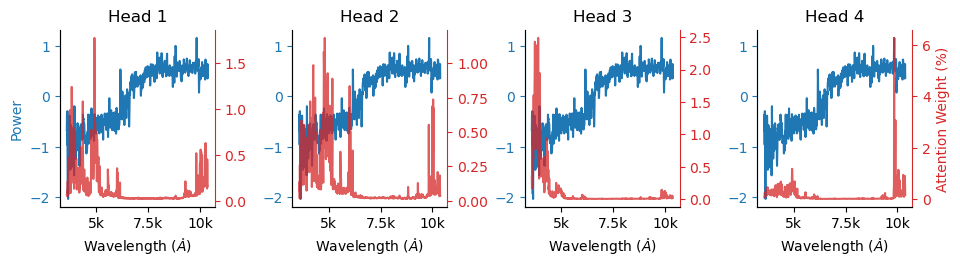

In [248]:
idx = 3

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_4.png', bbox_inches='tight', dpi=300)

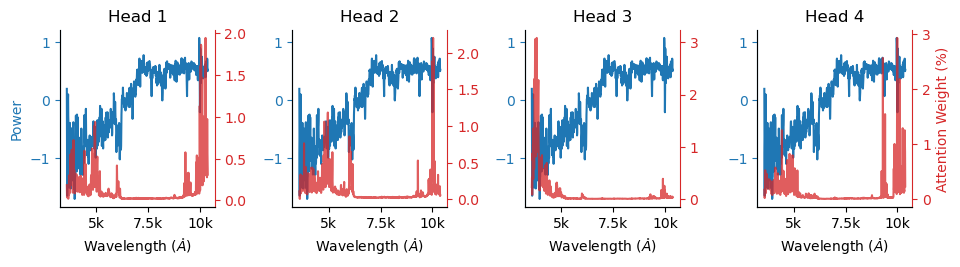

In [249]:
idx = 4

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_5.png', bbox_inches='tight', dpi=300)

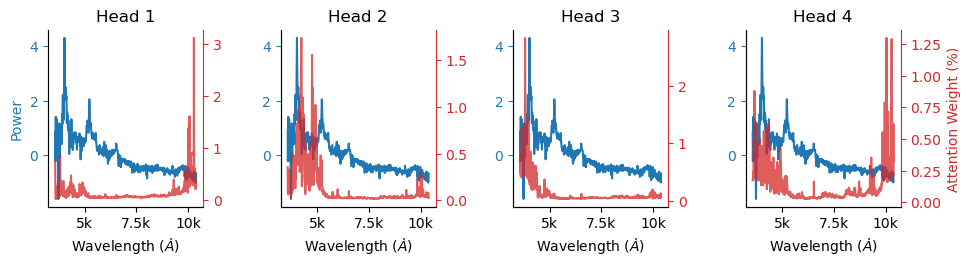

In [251]:
idx = 6

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_6.png', bbox_inches='tight', dpi=300)

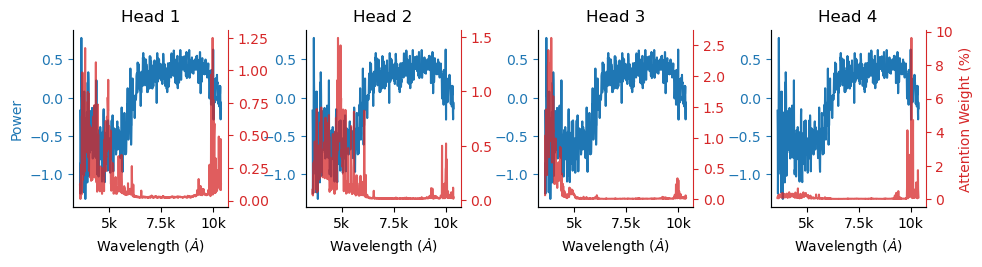

In [252]:
idx = 7

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_7.png', bbox_inches='tight', dpi=300)

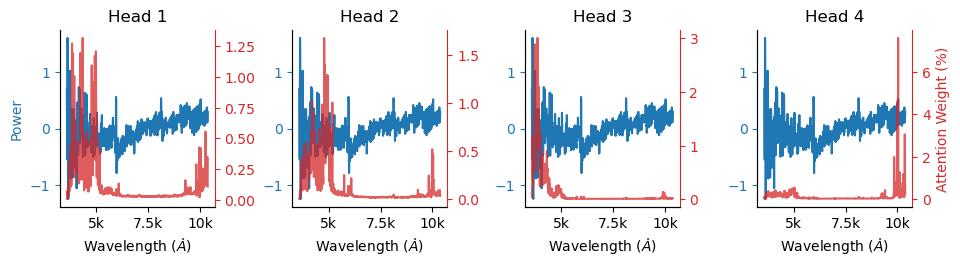

In [253]:
idx = 8

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_8.png', bbox_inches='tight', dpi=300)

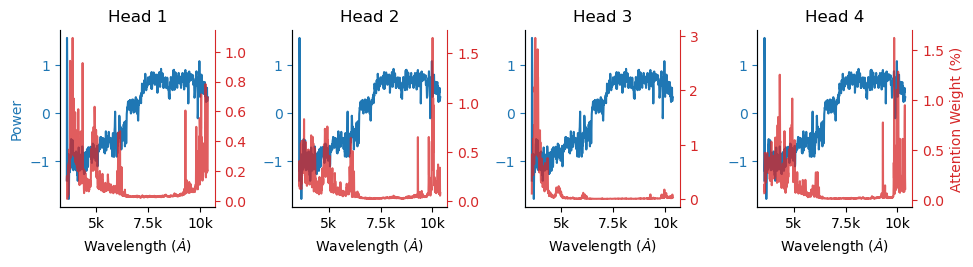

In [254]:
idx = 9

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_9.png', bbox_inches='tight', dpi=300)

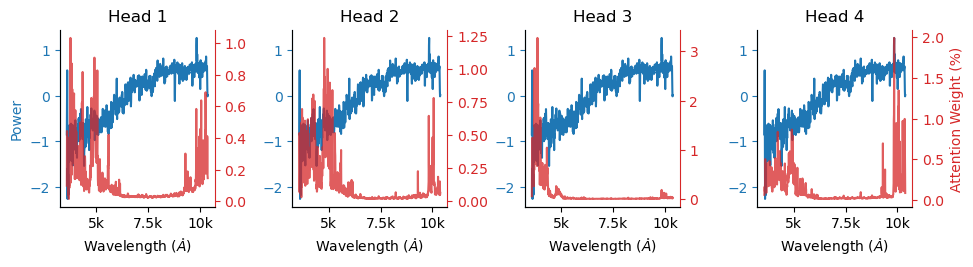

In [255]:
idx = 10

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_10.png', bbox_inches='tight', dpi=300)

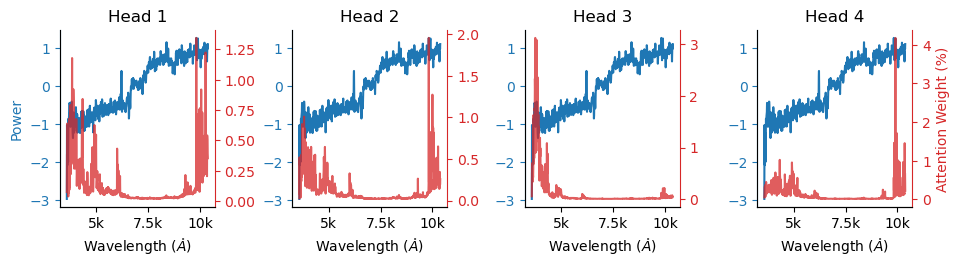

In [256]:
idx = 11

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_11.png', bbox_inches='tight', dpi=300)

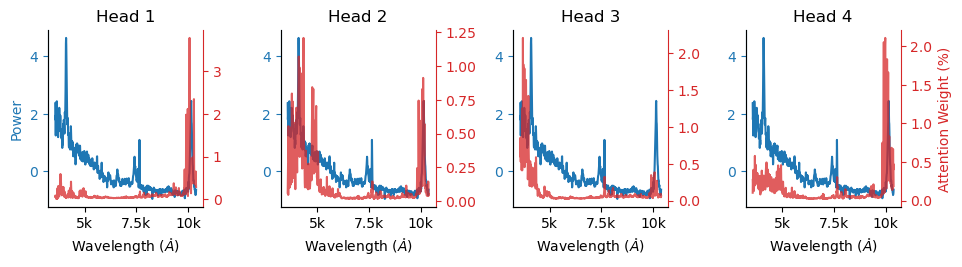

In [257]:
idx = 12

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_12.png', bbox_inches='tight', dpi=300)

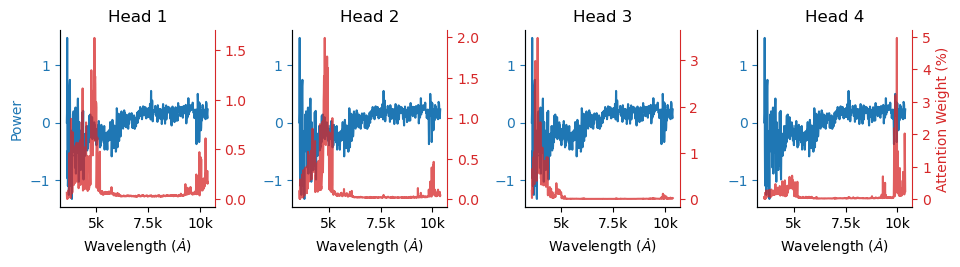

In [258]:
idx = 13

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_13.png', bbox_inches='tight', dpi=300)

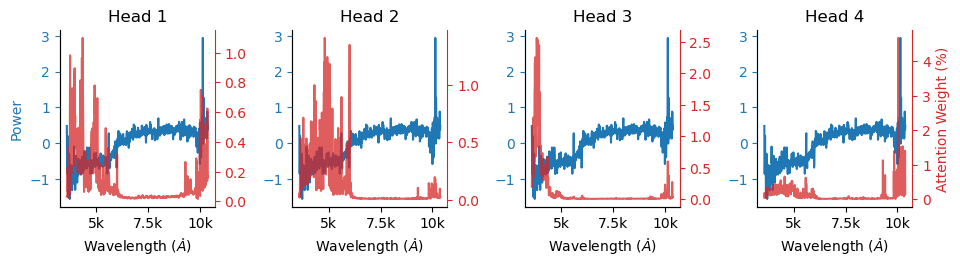

In [259]:
idx = 14

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_14.png', bbox_inches='tight', dpi=300)

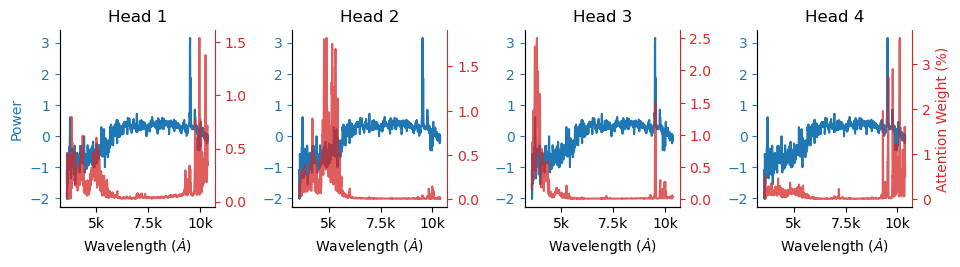

In [260]:
idx = 15

l = np.linspace(3586.7408577, 10372.89543574, 778-1)

# make a figure with 4 subplots in one row
fig, axes = subplots(1, 4, figsize=(11, 2.3))


spec = fnc(batch_test['spectrum'])[idx].squeeze().cpu().numpy()
att_weights = CLIP(batch_test['spectrum'].squeeze()[idx:idx+1].to('cuda'), False, return_weights=True)[1].squeeze()

for i, ax in enumerate(axes):
    ax.plot(l, spec[1:,2:].mean(1), color='tab:blue', label='spectrum')

    ax.set_xlabel('Wavelength ($\mathring{A}$)')
    ax.set_xticks([5000,7500,10000],['5k','7.5k','10k'])

    ax2 = ax.twinx()
    att_weight = att_weights[i]
    ax2.plot(l, att_weight.squeeze().data.cpu()[1:]*100, label='attention weight', color='tab:red', alpha=0.75)
    sns.despine(ax=ax, top=True, right=True)
    sns.despine(ax=ax2, top=True, left=False, right=False)

    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    ax2.spines['right'].set_color('tab:red')
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    ax.spines['left'].set_color('tab:blue')

    ax.set_title(f'Head {i+1}')

    

ax2.set_ylabel('Attention Weight (%)', color='tab:red')
plt.subplots_adjust(wspace=.5)
# plt.tight_layout()

axes[0].set_ylabel('Power', color='tab:blue')
label = axes[0].get_ylabel()
position = axes[0].yaxis.get_label().get_position()

# Shift the x-coordinate to the right (e.g., by adding 0.1 to the current x-coordinate)
new_position = (position[0] + 1000.1, position[1])
axes[0].set_ylabel('Power', color='tab:blue')
axes[0].yaxis.get_label().set_position(new_position)

plt.savefig('attention_15.png', bbox_inches='tight', dpi=300)